In this notebook, we collect stock price data from yahoo finance, a media property that is part of Yahoo!'s network. <br> 
We utilize the api https://pypi.org/project/yahoo-finance/ by Ran Aroussi. <br>
Credits: Rohan Joseph https://towardsdatascience.com/downloading-historical-stock-prices-in-python-93f85f059c1f

In [1]:
# import libraries to plot the data 
import matplotlib.pyplot as plt
import seaborn

# import data and numerical libraries 
import pandas as pd
import numpy as np

import sys
!{sys.executable} -m pip install yfinance
import yfinance as yf
import datetime
import time
import requests
import io
from collections import deque

In [2]:
# Time period for stock data
from datetime import date
start = datetime.datetime(2016,2,28)
end = datetime.datetime(2021, 2, 28)

In [3]:
LegacyCodeToDownloadSymbolList=''' Get stock ticker symbols listed on NASDAQ
url="https://pkgstore.datahub.io/core/nasdaq-listings/nasdaq-listed_csv/data/7665719fb51081ba0bd834fde71ce822/nasdaq-listed_csv.csv"
s = requests.get(url).content
companies = pd.read_csv(io.StringIO(s.decode('utf-8')))'''

In [4]:
# Symbols = companies['Symbol'].tolist()

In [185]:
# create empty dataframe
stock_final = pd.DataFrame()
df = pd.read_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\StockMarketSymbolList.csv")
num_symbols = len(df)
print(num_symbols)

results_csv_path = r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\AppleData\10W_Win_4W_Wait_Apple_Price_Change.csv"

# Period to be used for the window. Value = # of business days
window_period = 70

# Period of days after window_period that we are evaluating the price for
waiting_period = 28


df_slice = df.iloc[0:20]
symbol_list_temp=df_slice['Symbol'].tolist()

# List of symbols that don't have future data so they must be removed
symbols_to_remove=['AAVL', 'ABAX', 'ABCD', 'ACFC']
for item in symbols_to_remove:
    symbol_list_temp.remove(item)

print(symbol_list_temp)


#symbol_list_temp = ['AMD', 'NFLX', 'KO', 'FB', 'DIS', 'SBUX','BAC']
symbol_list_temp2 = ['MSFT', 'AAPL', 'TSLA', 'AMD', 'SPY', 'DKNG', 'NFLX']

symbol_list_temp = ['AAPL']

print(symbol_list_temp)

# iterate over each symbol
for i in symbol_list_temp:  
    
    # print the symbol which is being downloaded
    #print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

1914
['AAIT', 'AAL', 'AAME', 'AAOI', 'AAON', 'AAPL', 'AAWW', 'AAXJ', 'ABCB', 'ABCO', 'ABIO', 'ABMD', 'ACAD', 'ACET', 'ACFN', 'ACGL']
['AAPL']


In [186]:
stock_final
#print(len(Symbols))
#print(len(symbol_list_final))

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2016-02-29,24.215000,24.557501,24.162500,24.172501,22.483057,140865200,AAPL
2016-03-01,24.412500,25.192499,24.355000,25.132500,23.375963,201628400,AAPL
2016-03-02,25.127501,25.222500,24.910000,25.187500,23.427116,132678400,AAPL
2016-03-03,25.145000,25.427500,25.112499,25.375000,23.601511,147822800,AAPL
2016-03-04,25.592501,25.937500,25.342501,25.752501,23.952627,184220400,AAPL
...,...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103916400,AAPL
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,158273000,AAPL
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,111039900,AAPL


In [187]:


rsi_over_period_list =[]

# List to hold all RSI values, will be used for df column. Initializes moving average period for RSI to 14
rsi_list =[]
rsi_moving_average_period = 14

# rsi values that are meant to determine if a stock is under valued or over valued
rsi_under_value = 30
rsi_over_value = 70

# lists to store whether or not a stock's RSI is over or under valued on a given day
rsi_under_value_list = []
rsi_over_value_list = []

# List to store the moving average of closing prices over the selected moving_average_period
moving_average_list = []
moving_average_period = 100

period_moving_average_list =[]

# list to store if the price went up or not with False for a decrease and True for an increase
price_increase_list =[]

# List to store the change in price from day to day for a given stock
price_change_list =[]

# List to show if the price increased on the following day
next_day_price_increase_list = []

# List to show how much the price changed on the following day
next_day_price_change_list = []

# the period of time required to collect the previous closing values to calculate the initial RSI values
# 50 days was chosen as it should always contain 14 business days required for the previous values for moving averages
prev_data_period = datetime.timedelta(days = 290)
prev_start = start - prev_data_period

# iterate through all of our selected symbols
for symbol in symbol_list_temp:
    # Initialize variables for calculating RSI, Reset for each company 
    # day count initialized to 1 to account for the current day when starting
    day_count = 1
    
    gains = deque([])
    losses = deque([])
    
    closing_list = deque([])
    rsi_queue = deque([])
    volume_queue = deque([])
    price_change_queue = deque([])

    
    min_queue = deque([])
    max_queue = deque([])
    
    min_running_total = 0.0
    max_running_total = 0.0    
    volume_running_total = 0.0
    closing_running_total = 0.0
    price_change_running_total = 0.0
    
    moving_average = 0.0
    previous_val = 0.0
    total_gain = 0.0
    total_loss = 0.0
    stock = stock_final[stock_final['Name']==symbol]
    
    # Generates previous values so that moving averages can be found for all elements
    prev_stock = yf.download(symbol ,start=prev_start, end=start, progress=False)
    step = 0
    prev_length = len(prev_stock.Close)
    for c in prev_stock.Close:
        
        # if the number of closing values is less than the moving average period - 1 + the current step number(0, 1, 2...)
        if(prev_length <= (moving_average_period -1)+ step):
            closing_list.append(c)
            closing_running_total = closing_running_total + c
        
        # Makes sure only the last 13 values get put into gains and losses
        if(prev_length > (rsi_moving_average_period - 1) + step):
            lastVal = c
            step = step + 1            
            continue
        
        # Only gets reached for the last 13 values 
        change = c - lastVal
        lastVal = c

        
        if(change > 0.0):
            total_gain = total_gain + change
            gains.append(change)
            losses.append(0.0)

        else:
            total_loss = total_loss + abs(change)
            losses.append(abs(change))
            gains.append(0.0)

        step = step + 1
    # boolean flag to determine if the current value is not the first one
    not_first_value = False
    # Iterates through all the Closing values of our selected company
    for c in stock['Close']:
        # Calculates price change from previous day
        change = c -lastVal 
        if(not_first_value):
            next_day_price_change_list.append(change)
            next_day_price_increase_list.append(change > 0)
        lastVal = c
        closing_list.append(c)
        price_change_list.append(change)
        not_first_value = True
        
        
        
        # If the stock price went up add the change and -1 to the gains and losses list respectively
        # price_increase_list will contain 'True' for a positive value and a 'False' for a negative value
        if (change > 0.0):
            total_gain = total_gain + change
            gains.append(change)
            losses.append(0.0)
            price_increase_list.append(True)
        # If the stock price went down add the change and -1 to the losses and gains list respectively
        else:
            total_loss = total_loss + abs(change)
            losses.append(abs(change))
            gains.append(0.0)
            price_increase_list.append(False)
            
        # Calculates moving average of closing price over the selected moving_average_period
        closing_running_total = closing_running_total + c

        temp_moving_average = closing_running_total / moving_average_period
        moving_average_list.append(temp_moving_average)
        closing_running_total = closing_running_total - closing_list.popleft()
            
        # Calulates 14 day moving average for gains and losses of the given stock
        avg_gain = total_gain / rsi_moving_average_period
        avg_loss = total_loss / rsi_moving_average_period
        rs = avg_gain / (avg_loss+0.001)
        rsi = abs(100.0 - (100.0 / (1.0 + rs)))
        
        # Determines if the RSI is under, over, or in between our underpriced and overpriced RSI values
        if(rsi>rsi_over_value):
            rsi_over_value_list.append(True)
            rsi_under_value_list.append(False)
        elif(rsi < rsi_under_value):
            rsi_over_value_list.append(False)
            rsi_under_value_list.append(True)
        else:
            rsi_over_value_list.append(False)
            rsi_under_value_list.append(False)
        rsi_list.append(rsi)
            
        # Removes the first value from both gains and losses while also subtracting them from their total values
        total_gain = total_gain - gains.popleft()
        total_loss = total_loss - losses.popleft()
            
        #Print statements used for debugging project
        #print("Current symbol is ", symbol)
        #print("rs value is ", rs)
        #print("rsi = ", rsi)
    next_day_price_change_list.append(next_day_price_change_list[len(price_change_list)-2])
    next_day_price_increase_list.append(next_day_price_increase_list[len(price_change_list)-2])
print(len(price_change_list))        
# Checks to see if the RSI column already exists, if it doesn't exist then the column is created
# Inserts the newly-created RSI list as a column in our stock_final DataFrame
# Price Increase will contain 'False' if the price decreased from the previous day or 'True' if the price increased

if 'Price Increase' not in stock_final:
    stock_final.insert(6, "Price Increase", price_increase_list, False)
if 'Price Change' not in stock_final:
    stock_final.insert(7, "Price Change", price_change_list, False)
if 'NextDay Price Increase' not in stock_final:
    stock_final.insert(8, "NextDay Price Increase", next_day_price_increase_list, False)
if 'NextDay Price Change' not in stock_final:
    stock_final.insert(9, "NextDay Price Change", next_day_price_change_list, False)
if '2W MA' not in stock_final:
    stock_final.insert(10, "2W MA", moving_average_list, False)
if 'RSI' not in stock_final:
    stock_final.insert(11, "RSI", rsi_list, False)
if 'RSI Over' not in stock_final:
    stock_final.insert(12, "RSI Over", rsi_over_value_list, False)    
if 'RSI Under' not in stock_final:
    stock_final.insert(13, "RSI Under", rsi_under_value_list, False)    


1259


In [188]:
stock_final

,Open,High,Low,Close,Adj Close,Volume,Price Increase,Price Change,NextDay Price Increase,NextDay Price Change,2W MA,RSI,RSI Over,RSI Under,Name
Date,,,,,,,,,,,,,,,
2016-02-29,24.215000,24.557501,24.162500,24.172501,22.483057,140865200,False,-0.055000,True,0.959999,26.923750,56.088780,False,False,AAPL
2016-03-01,24.412500,25.192499,24.355000,25.132500,23.375963,201628400,True,0.959999,True,0.055000,26.896800,65.982751,False,False,AAPL
2016-03-02,25.127501,25.222500,24.910000,25.187500,23.427116,132678400,True,0.055000,True,0.187500,26.871725,69.284354,False,False,AAPL
2016-03-03,25.145000,25.427500,25.112499,25.375000,23.601511,147822800,True,0.187500,True,0.377501,26.851725,72.998348,True,False,AAPL
2016-03-04,25.592501,25.937500,25.342501,25.752501,23.952627,184220400,True,0.377501,False,-0.285000,26.828950,74.822785,True,False,AAPL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,128.009995,129.720001,125.599998,126.000000,126.000000,103916400,False,-3.869995,False,-0.139999,124.612400,27.164759,False,True,AAPL
2021-02-23,123.760002,126.709999,118.389999,125.860001,125.860001,158273000,False,-0.139999,False,-0.510002,124.730100,23.331724,False,True,AAPL
2021-02-24,124.940002,125.559998,122.230003,125.349998,125.349998,111039900,False,-0.510002,False,-4.360001,124.825500,24.090527,False,True,AAPL


In [189]:
# Get stock data as a CSV file
# df_temp = pd.DataFrame(symbol_list)
# df_temp.to_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\SymbolListFinal.csv")
#stock_final.to_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\StockMarketData2.csv")
#stock_final.to_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\AMD_Market_Data.csv")

In [190]:
# This section of code is an adapted version which takes a window size into account 

In [191]:
# Path to the CSV file for saving. Up here for easy editing
window_csv_path = r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\70D_Win_1W_Wait_Temp_Group_Data.csv"


price_after_waiting_period_list =[]

# List to show how much the price changed after the window period
price_change_over_window_list =[]
price_increase_over_window_list = []

price_increase_as_int_list =[]

# Lists to hold the min and max values over the given period
min_over_window_list =[]
max_over_window_list =[]

# Lists that state if a given stock was undersold or oversold based on RSI values. 
rsi_oversold_window_list = []
rsi_undersold_window_list = []

# Lists to hold all the average values over the given period
rsi_over_window_list =[]
close_over_window_list=[]

avg_price_change_list = []

volume_over_window_list =[]
avg_volume_over_window_list = []

max_volume_over_window_list =[]
min_volume_over_window_list =[]

# List to store whether or not the price went up following the waiting period after a given window frame of days
waiting_period_price_increase_list = []
waiting_period_price_change_list = []

# iterate through all of our selected symbols
for symbol in symbol_list_temp:
    # Initialize variables for calculating RSI, Reset for each company 
    # day count initialized to 1 to account for the current day when starting
    day_count = 1
    gains = deque([])
    losses = deque([])
    closing_queue = deque([])
    rsi_queue = deque([])
    volume_queue = deque([])
    price_change_queue = deque([])
    
    # queue of RSI over 14 days instead of window period. (standard RSI)
    rsi_14_closing_queue = deque([])
    
    
    # count variables for testing
    volume_count = 0
    close_count = 0
    min_count =0
    max_count = 0
    

    # Queues to contain most recent min and max values for window_min and window_max 
    min_queue = deque([])
    max_queue = deque([])
    
    min_running_total = 0.0
    max_running_total = 0.0
    volume_running_total = 0.0
    closing_running_total = 0.0
    price_change_running_total = 0.0
    
    moving_average = 0.0
    previous_val = 0.0
    total_gain = 0.0
    total_loss = 0.0
    stock = stock_final[stock_final['Name']==symbol]
    
    # Generates previous values so that moving averages can be found for all elements
    prev_stock = yf.download(symbol ,start=prev_start, end=start, progress=False)
    step = 0
    prev_length = len(prev_stock.Close)
    
    # Loops to iterate through the previous stock values to collect all information neccesarry for calculations
    
    # Iterates through all the low values of the stock to get the previous 29 low values for calculations
    for min_val in prev_stock.Low:
        if(prev_length <= (window_period-1) + step):
            min_queue.append(min_val)
            min_running_total = min_running_total + min_val
            
            min_count = min_count + 1
        step = step + 1
            
    step = 0
    # Iterates through all the high values of the stock to get the previous 29 high values for calculations
    for max_val in prev_stock.High:
        if(prev_length <= (window_period-1)  + step):
            max_queue.append(max_val)
            max_running_total = max_running_total + max_val
            
            max_count = max_count + 1
        step = step + 1
    
    step = 0
    # Iterates through all the volume values of the stock to get the previous 29 volume values for calculations
    for volume in prev_stock.Volume:
        if(prev_length <= (window_period -1) + step):
            volume_queue.append(volume)
            volume_running_total = volume_running_total + volume
            volume_count = volume_count + 1
        step = step + 1
            
    step = 0
    for c in prev_stock.Close:
        
        # if the number of closing values is less than the window period - 1 + the current step number(0, 1, 2...)
        if(prev_length >= (window_period)+ step):
            lastVal = c
            step = step + 1
            continue
            
        
        # Only gets reached for the last (window_period-1) values 
        closing_queue.append(c)
        change = c - lastVal
        lastVal = c
        price_change_queue.append(change)
        price_change_running_total = price_change_running_total + change
        closing_running_total = closing_running_total + c
        
        close_count = close_count +1

        
        if(change > 0.0):
            total_gain = total_gain + change
            gains.append(change)
            losses.append(0.0)

        else:
            total_loss = total_loss + abs(change)
            losses.append(abs(change))
            gains.append(0.0)

        step = step + 1

    
    # Iterates through all the volume values for our selected company
    for volume in stock['Volume']:
        volume_queue.append(volume)
        
        # Initializes temporary values for min and max volumes
        volume_temp_min = 10000000000000000000000000
        volume_temp_max = 0
        
        
        volume_running_total = volume_running_total + volume
        vol_avg = volume_running_total / window_period
        volume_over_window_list.append(volume_running_total)
        avg_volume_over_window_list.append(vol_avg)
        
        # Determines if the volume value is outside the current window max/min
        for value in volume_queue:
            if value > volume_temp_max:
                volume_temp_max = value
            if value < volume_temp_min:
                volume_temp_min = value
        max_volume_over_window_list.append(volume_temp_max)
        min_volume_over_window_list.append(volume_temp_min)

        # Removes the first entered volume value for the next moving average instance.
        volume_running_total = volume_running_total - volume_queue.popleft()
        
        
    
    for minV in stock['Low']:
        min_queue.append(minV)
        temp_min_val = 10000
        min_running_total = min_running_total + minV
        for value in min_queue:
            if value < temp_min_val:
                temp_min_val = value
                
        min_over_window_list.append(temp_min_val)
        min_running_total = min_running_total - min_queue.popleft()
        
        
    for maxV in stock['High']:
        max_queue.append(maxV)
        temp_max_val = 0
        max_running_total = max_running_total + maxV
        for value in max_queue:
            if value > temp_max_val:
                temp_max_val = value
                
        max_over_window_list.append(temp_max_val)
        max_running_total = max_running_total - max_queue.popleft()
        
    # boolean flag to determine if the current value is not the first one
    not_first_value = False       
    temp_step_counter = 1
    week_old_queue = deque([])
    
    # Iterates through all the Closing values of our selected company
    for c in stock['Close']:
        week_old_queue.append(c)
        
        # Calculates price change from previous day
        change = c -lastVal 
        #if(temp_step_counter == 0):
        price_change_over_window_list.append(change)
        price_increase_over_window_list.append(change > 0)
        lastVal = c
        closing_queue.append(c)
        price_change_queue.append(change)
        price_change_running_total = price_change_running_total + change
        avg_price_change_list.append(price_change_running_total / window_period)
        price_change_running_total = price_change_running_total - price_change_queue.popleft()
        
        # If we have filled up the 7 day closing queue by having at least 7 iteartions 
        if(temp_step_counter >= waiting_period):
            price_after_waiting_period_list.append(c)
            
            # Stores removed value into a variable for use
            temp_old_val = week_old_queue.popleft()
            
            seven_day_increase = c > temp_old_val
            waiting_period_price_increase_list.append(seven_day_increase)
            waiting_period_price_change_list.append(c - temp_old_val)
            
            # Gets the seven day price increase as a numerical value for use
            if(seven_day_increase):
                price_increase_as_int_list.append(1)
            else:
                price_increase_as_int_list.append(0)
        temp_step_counter = temp_step_counter + 1
        
        
        
        # If the stock price went up add the change and -1 to the gains and losses list respectively
        # price_increase_list will contain 'True' for a positive value and a 'False' for a negative value
        if (change > 0.0):
            total_gain = total_gain + change
            gains.append(change)
            losses.append(0.0)
        # If the stock price went down add the change and -1 to the losses and gains list respectively
        else:
            total_loss = total_loss + abs(change)
            losses.append(abs(change))
            gains.append(0.0)
            
        # Calculates moving average of closing price over the selected moving_average_period (window_period)
        closing_running_total = closing_running_total + c

        temp_moving_average = closing_running_total / window_period
        close_over_window_list.append(temp_moving_average)
        closing_running_total = closing_running_total - closing_queue.popleft()
            
        # Calulates (window_per) day moving average for gains and losses of the given stock
        avg_gain = total_gain / window_period
        avg_loss = total_loss / window_period
        rs = avg_gain / avg_loss
        rsi = abs(100.0 - (100.0 / (1.0 + rs)))
        
        # Determines if the RSI is under, over, or in between our underpriced and overpriced RSI values
        '''if(rsi>rsi_over_value):
            rsi_oversold_window_list.append(True)
            rsi_undersold_window_list.append(False)
        elif(rsi < rsi_under_value):
            rsi_oversold_window_list.append(False)
            rsi_undersold_window_list.append(True)
        else:
            rsi_oversold_window_list.append(False)
            rsi_undersold_window_list.append(False)
        '''
        
        rsi_over_window_list.append(rsi)
            
        # Removes the first value from both gains and losses while also subtracting them from their total values
        total_gain = total_gain - gains.popleft()
        total_loss = total_loss - losses.popleft()
        
    debug_stuff='''
    print("7 day price change count: ", len(price_after_waiting_period_list))   
    print("close count = ", close_count)
    print("min count = ", min_count)
    print("max count = ", max_count)
    print("volume count = ", volume_count)
            
    print(len(price_change_over_window_list))
    '''
    
    # Gets the last window_period number of results for the truth values
    future_data_period = datetime.timedelta(days = 50)
    new_start_date = end + datetime.timedelta(days = 1)
    new_end_date = new_start_date + future_data_period
    post_stock = yf.download(symbol ,start=new_start_date, end=new_end_date, progress=False)
    
    
    # Appends the last window_period of values to the lists for DataFrame
    post_length = len(post_stock['Close'])
    post_step = 1
    for post_c in post_stock['Close']:
        #print("post step is ",post_step, ", length of week queue: ", len(week_old_queue))
        if(post_step < waiting_period):
            week_old_queue.append(post_c)
            price_after_waiting_period_list.append(post_c)
            
            # Temp variable to store the removed value for use
            week_old_temp = week_old_queue.popleft()
            seven_day_increase = post_c > week_old_temp
            waiting_period_price_increase_list.append(seven_day_increase)
            waiting_period_price_change_list.append(post_c - week_old_temp)
            
            # Gets the seven day price increase as a numerical value for use
            if(seven_day_increase):
                price_increase_as_int_list.append(1)
            else:
                price_increase_as_int_list.append(0)
            post_step = post_step + 1
 
            
       
    
    # Repeats the last 7 values to fill up the last 7 days of "7 day price increase"
    '''
    iterator = 0
    for iterator in range(waiting_period):
        price_after_waiting_period_list.append(price_after_waiting_period_list[len(price_after_waiting_period_list)-(iterator+1)])
        waiting_period_price_increase_list.append(waiting_period_price_increase_list[len(waiting_period_price_increase_list)-(iterator+1)])
    '''
        
        
    print(len(price_after_waiting_period_list))
    #print(price_after_waiting_period_list)
    print(len(max_over_window_list))

    
    

    
    
    
    #price_change_over_window_list.append(price_change_over_window_list[len(volume_over_window_list)-1])
    #price_increase_over_window_list.append(price_increase_over_window_list[len(volume_over_window_list)-2])
   

1259
1259


In [192]:
# List of column names to be added to the data frame at the end
column_names = ["Total Vol", "Avg Vol", "Min Vol", 
                "Max Vol", "Min", "Max",  
                "Window MA", "100D MA", "RSI 2W", 
                "RSI Window", "Price Change", "Price Increase", 
                "1W Price Increase","Avg Price Change", "1W Price Change",
                "RSI Oversold", "RSI Undersold"]

# List of list names that contains column data
list_names = [volume_over_window_list, avg_volume_over_window_list, min_volume_over_window_list, 
              max_volume_over_window_list, min_over_window_list, max_over_window_list, 
              close_over_window_list, moving_average_list, rsi_list,
              rsi_over_window_list, price_change_over_window_list, price_increase_over_window_list, 
              price_increase_as_int_list, avg_price_change_list, waiting_period_price_change_list,
              rsi_over_value_list, rsi_under_value_list]

print("column count: ", len(column_names), " and list count: ", len(list_names))
# Creates the DataFrame out of the generated lists. Checks to see if each column exists before adding it to prevent duplicates
stock_average = pd.DataFrame()
column_count = 0
for column_count in range(len(column_names)):
    print(column_count)
    print(column_names[column_count], ": has length of ",len(list_names[column_count]))
    column_name = column_names[column_count]
    list_name = list_names[column_count]
    print(len(list_name))
    if column_name not in stock_average:
        stock_average.insert(column_count, column_name, list_name, False)


column count:  17  and list count:  17
0
Total Vol : has length of  1259
1259
1
Avg Vol : has length of  1259
1259
2
Min Vol : has length of  1259
1259
3
Max Vol : has length of  1259
1259
4
Min : has length of  1259
1259
5
Max : has length of  1259
1259
6
Window MA : has length of  1259
1259
7
100D MA : has length of  1259
1259
8
RSI 2W : has length of  1259
1259
9
RSI Window : has length of  1259
1259
10
Price Change : has length of  1259
1259
11
Price Increase : has length of  1259
1259
12
Window Price Increase : has length of  1259
1259
13
Avg Price Change : has length of  1259
1259
14
Window Price Change : has length of  1259
1259
15
RSI Oversold : has length of  1259
1259
16
RSI Undersold : has length of  1259
1259


In [193]:
stock_average

,Total Vol,Avg Vol,Min Vol,Max Vol,Min,Max,Window MA,100D MA,RSI 2W,RSI Window,Price Change,Price Increase,Window Price Increase,Avg Price Change,Window Price Change,RSI Oversold,RSI Undersold
0,1.322160e+10,1.888801e+08,52185600,533478800,23.097500,29.980000,26.081786,26.923750,56.088780,41.566205,-0.055000,False,1,-0.062464,2.962500,False,False
1,1.331276e+10,1.901824e+08,52185600,533478800,23.097500,29.980000,26.034786,26.896800,65.982751,43.852761,0.959999,True,1,-0.047000,2.032501,False,False
2,1.325874e+10,1.894106e+08,52185600,533478800,23.097500,29.980000,25.975714,26.871725,69.284354,42.021992,0.055000,True,1,-0.059071,2.067499,False,False
3,1.323338e+10,1.890483e+08,52185600,533478800,23.097500,29.980000,25.914000,26.851725,72.998348,41.605128,0.187500,True,1,-0.061714,2.235001,True,False
4,1.328046e+10,1.897208e+08,52185600,533478800,23.097500,29.965000,25.855821,26.828950,74.822785,42.161483,0.377501,True,1,-0.058179,2.257500,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,7.173225e+09,1.024746e+08,46691300,192541500,112.589996,145.089996,128.315000,124.612400,27.164759,53.821255,-3.869995,False,0,0.138286,-3.849998,False,True
1255,7.193474e+09,1.027639e+08,46691300,192541500,112.589996,145.089996,128.456286,124.730100,23.331724,53.910638,-0.139999,False,0,0.141286,-2.860001,False,True
1256,7.192219e+09,1.027460e+08,46691300,192541500,112.589996,145.089996,128.540000,124.825500,24.090527,52.373624,-0.510002,False,1,0.083714,0.550003,False,True
1257,7.237256e+09,1.033894e+08,46691300,192541500,112.589996,145.089996,128.565429,124.867500,3.140279,50.697929,-4.360001,False,1,0.025429,5.220001,False,True


In [183]:
window_csv_path = r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\70D_Win_1W_Wait_Temp_Group_Price_Change.csv"
# Get stock data as a CSV file
# df_temp = pd.DataFrame(symbol_list)
# df_temp.to_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\SymbolListFinal.csv")
#stock_final.to_csv(r"C:\Users\sam\Documents\000 KSU Final\CIS 590\StockData\StockMarketData2.csv")
stock_average.to_csv(results_csv_path)

In [184]:
stock_average.describe()

,Total Vol,Avg Vol,Min Vol,Max Vol,Min,Max,Window MA,100D MA,RSI 2W,RSI Window,Price Change,1W Price Increase,Avg Price Change,1W Price Change
count,1.259000e+03,1.259000e+03,1.259000e+03,1.259000e+03,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000
mean,9.297448e+09,1.328207e+08,6.326984e+07,3.429854e+08,44.673020,59.504120,52.091316,50.955558,58.240351,56.745144,0.077071,0.675933,0.081374,2.063493
std,1.893145e+09,2.704493e+07,1.406336e+07,8.451344e+07,21.213507,32.246118,25.983148,24.696800,17.963982,9.122909,1.375434,0.468211,0.149891,6.805636
min,6.601353e+09,9.430504e+07,4.544800e+07,1.925415e+08,22.367500,26.537500,24.277286,24.991575,3.140279,34.811815,-10.519997,0.000000,-0.284214,-25.707504
25%,7.669071e+09,1.095582e+08,5.005560e+07,2.717428e+08,33.742500,39.162498,36.045679,34.565712,45.647168,51.248569,-0.267500,0.000000,0.009018,-0.795001
50%,8.817911e+09,1.259702e+08,5.879000e+07,3.463752e+08,38.000000,49.422501,44.422500,44.351800,60.304630,55.722058,0.037500,1.000000,0.051857,1.990002
75%,1.064430e+10,1.520614e+08,7.718900e+07,4.265100e+08,50.250000,67.000000,58.328107,56.163913,71.556715,62.037836,0.455002,1.000000,0.116214,4.923752
max,1.397947e+10,1.997067e+08,9.252240e+07,5.334788e+08,112.589996,145.089996,128.594000,124.949900,95.623644,81.937997,10.070000,1.000000,0.777964,41.564995


In [118]:
#check missing data
stock_final.isna().sum()

Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
Price Increase            0
Price Change              0
NextDay Price Increase    0
NextDay Price Change      0
2W MA                     0
RSI                       0
RSI Over                  0
RSI Under                 0
Name                      0
dtype: int64

In [132]:
# number of companies with stock data
stock_final['Name'].nunique()

1

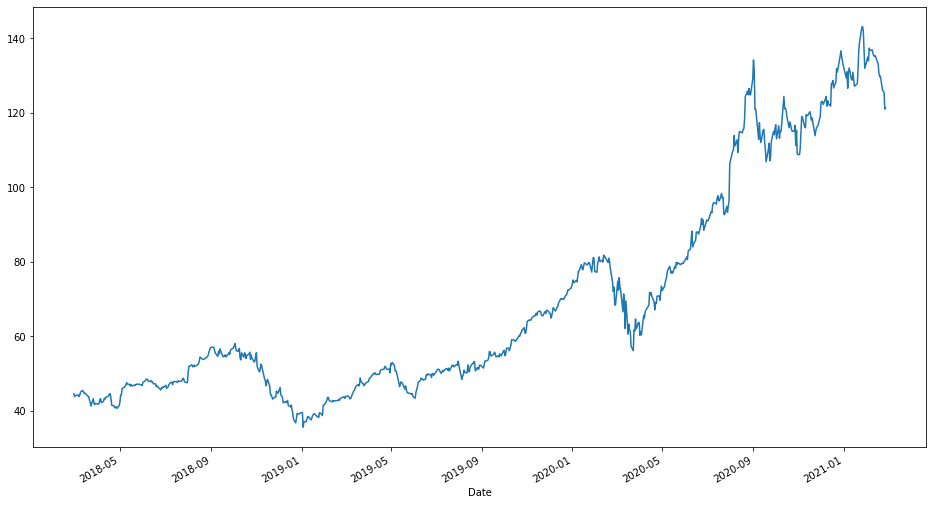

In [150]:
# Plot the stock's closing prices against the dates
stock_final['Close'].plot(figsize=(16, 9))
plt.show()

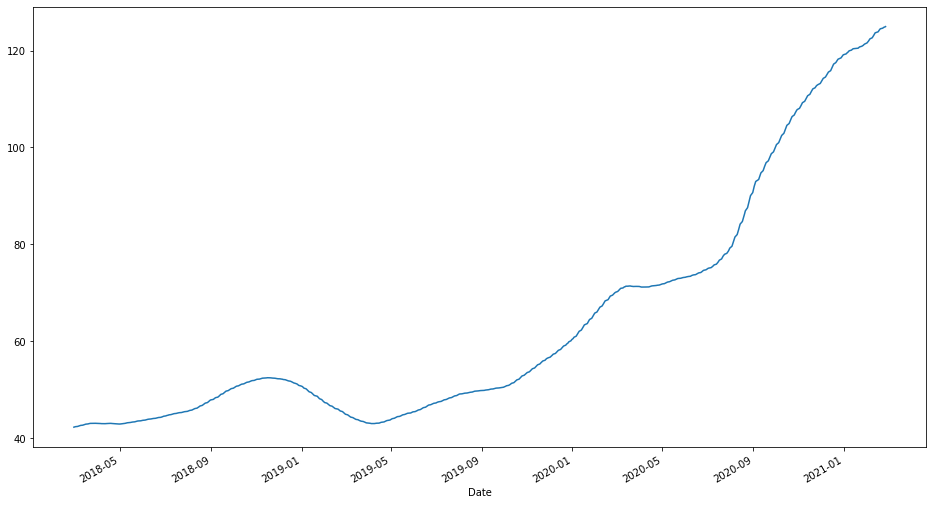

In [151]:
# Plot the stock's RSI value against the dates
stock_final['2W MA'].plot(figsize=(16, 9))
plt.show()

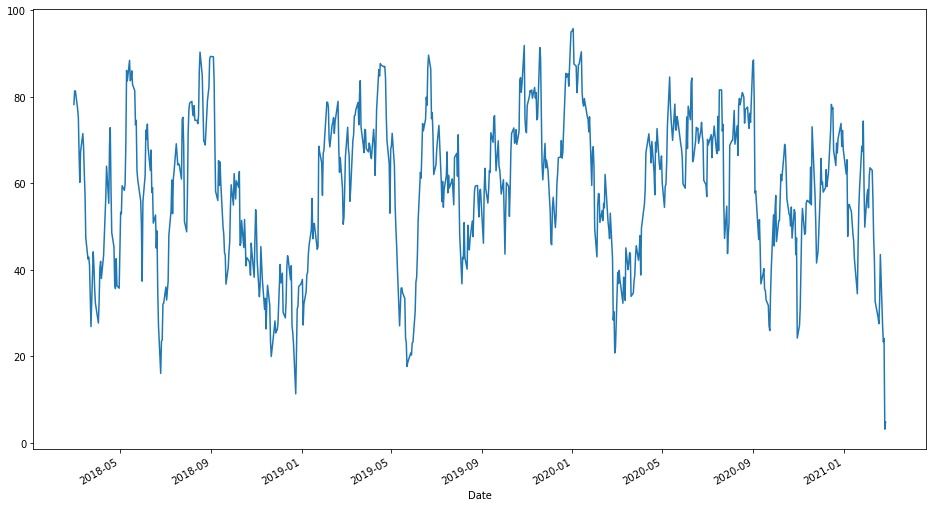

In [152]:
# Plot the moving average over the provided moving average period 
stock_final['RSI'].plot(figsize=(16, 9))
plt.show()

Define a certain window: month, year etc <br>
More like a fourier window: one year, one month? different window sizes. <br>
Inside the window, derive several descriptors to use ML for predicition <br>
Feature engineering <br>
Given maximum price, min price (two descriptors), derive the ratio, average price, standard deviation of the price, <br>
all time high price, time past since price peaked <br>
Skewness of the price. <br>
Plot histogram of the price, say with 10 bins of the fourier transform of the prices. <br>
Check how important the entropy is<br>
Linear regression coefficient of the price and the date <br>
Pearson coeeficient between price and date <br>
Take care of delisted companies on the url list of NASDAQ companies

In [ ]:
# Now to make a window size